# Setup

In [46]:
import os
import json
from collections import Counter

import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

from Bio import SeqIO

from IPython.display import display

In [36]:
SEQS_FASTA_FILE_PATH = '/cs/phd/nadavb/cafa_project/data/uniref90.fasta'
ANNOTATIONS_SQLITE_FILE_PATH = '/cs/phd/nadavb/cafa_project/data/protein_annotations.db'
SEQS_AND_ANNOTATIONS_CHUNKS_DIR = '/cs/phd/nadavb/cafa_project/data/seqs_and_annotations'

# Load annotations

In [7]:
cnx = sqlite3.connect(ANNOTATIONS_SQLITE_FILE_PATH)
go_annots = pd.read_sql_query('SELECT uniprot_name, complete_go_annotation_indices FROM protein_annotations', cnx)
display(go_annots)

,uniprot_name,complete_go_annotation_indices
0,A0A5A9P0L4_9TELE,[]
1,A0A410P257_9BACT,[]
2,A0A5A9Q4C1_9CETA,[]
3,UPI0011814A49,[]
4,UPI001186A1A9,[]
...,...,...
106555988,W8CWT7_9HIV1,[]
106555989,A0A1D8QFB5_9HIV1,[]
106555990,W8CWU3_9HIV1,[]
106555991,F1AU43_9RETR,[]


# Count unique annotations

In [43]:
annotation_index_counter = Counter()

for raw_annotation_indices in go_annots['complete_go_annotation_indices']:
    annotation_index_counter.update(json.loads(raw_annotation_indices))
    
annotation_index_counter = pd.Series(annotation_index_counter).sort_values(ascending = False)
display(annotation_index_counter)

10019    14077131
4205      4645778
2706      3605141
4396      2874126
24685     2413000
           ...   
44088           1
1871            1
11143           1
43873           1
11461           1
Length: 26032, dtype: int64

(array([4.846e+03, 7.013e+03, 6.299e+03, 3.559e+03, 2.174e+03, 1.591e+03,
        4.180e+02, 1.050e+02, 2.300e+01, 4.000e+00]),
 array([0.        , 0.71485142, 1.42970283, 2.14455425, 2.85940566,
        3.57425708, 4.28910849, 5.00395991, 5.71881132, 6.43366274,
        7.14851415]),
 <a list of 10 Patch objects>)

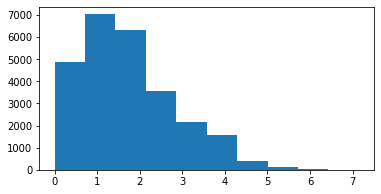

In [47]:
fig, ax = plt.subplots(figsize = (6, 3))
ax.hist(np.log10(annotation_index_counter))

In [52]:
(annotation_index_counter >= 300).sum()

5955

In [54]:
annotation_index_counter.to_csv('/cs/phd/nadavb/cafa_project/data/unique_annotations_counts.csv', header = False)

# Combine the annotations with the sequences

In [12]:
go_annots['expected_uniref_id'] = go_annots['uniprot_name'].apply(lambda uniprot_name: 'UniRef90_%s' % \
        uniprot_name.split('_')[0])
go_annots.set_index('expected_uniref_id', inplace = True)
display(go_annots)

,uniprot_name,complete_go_annotation_indices
expected_uniref_id,,
UniRef90_A0A5A9P0L4,A0A5A9P0L4_9TELE,[]
UniRef90_A0A410P257,A0A410P257_9BACT,[]
UniRef90_A0A5A9Q4C1,A0A5A9Q4C1_9CETA,[]
UniRef90_UPI0011814A49,UPI0011814A49,[]
UniRef90_UPI001186A1A9,UPI001186A1A9,[]
...,...,...
UniRef90_W8CWT7,W8CWT7_9HIV1,[]
UniRef90_A0A1D8QFB5,A0A1D8QFB5_9HIV1,[]
UniRef90_W8CWU3,W8CWU3_9HIV1,[]


In [25]:
uniref_id_to_annots_index = {uniref_id: i for i, uniref_id in enumerate(go_annots.index)}

In [38]:
CHUNK_SIZE = 1e06

current_chunk = []
chunk_index = 0
total_failed = 0

def save_chunk(i):
    global current_chunk, chunk_index, total_failed
    print('Saving chunk %d. Current index: %d, total failed: %d.' % (chunk_index, i, total_failed))
    pd.DataFrame(current_chunk, columns = ['annotation_index', 'uniref_id', 'uniprot_name', \
            'complete_go_annotation_indices', 'seq']).to_csv(os.path.join(SEQS_AND_ANNOTATIONS_CHUNKS_DIR, \
            'chunk_%d.csv' % chunk_index), index = False)
    current_chunk = []
    chunk_index += 1

for i, record in enumerate(SeqIO.parse(SEQS_FASTA_FILE_PATH, 'fasta')):
    
    try:
        annots_index = uniref_id_to_annots_index[record.id]
        uniprot_name, complete_go_annotation_indices = go_annots.iloc[annots_index]
        current_chunk.append((annots_index, record.id, uniprot_name, complete_go_annotation_indices, str(record.seq)))
    except KeyError:
        total_failed += 1
        
    if len(current_chunk) >= CHUNK_SIZE:
        save_chunk(i)
        
save_chunk(i)
print('Done.')

Saving chunk 0. Current index: 1349007, total failed: 349008.
Saving chunk 1. Current index: 2349007, total failed: 349008.
Saving chunk 2. Current index: 3349007, total failed: 349008.
Saving chunk 3. Current index: 4349007, total failed: 349008.
Saving chunk 4. Current index: 5349007, total failed: 349008.
Saving chunk 5. Current index: 6349007, total failed: 349008.
Saving chunk 6. Current index: 7349007, total failed: 349008.
Saving chunk 7. Current index: 8349007, total failed: 349008.
Saving chunk 8. Current index: 9349007, total failed: 349008.
Saving chunk 9. Current index: 10349007, total failed: 349008.
Saving chunk 10. Current index: 11349007, total failed: 349008.
Saving chunk 11. Current index: 12349007, total failed: 349008.
Saving chunk 12. Current index: 13349007, total failed: 349008.
Saving chunk 13. Current index: 14349007, total failed: 349008.
Saving chunk 14. Current index: 15349007, total failed: 349008.
Saving chunk 15. Current index: 16349007, total failed: 349